In [1]:
from util import *
%load_ext autoreload

In [128]:
%autoreload

# Gaussian Clusters Example

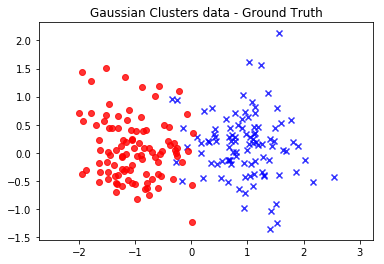

In [29]:
# Problem Setup --- Need to rework this example to be more general. I've made it so that the clusters are 
# in consecutive order for plotting m (0-99, 100-199). For this I had to re write the helper functions when 
# doing the Two moons dataset.

Ns = [100,100]
N = sum(Ns)
fs = 5
means = [np.array([1.0,0.]), np.array([-1.0,0.])]
Covs = [0.3*np.eye(2), 0.3*np.eye(2)]

# define fidelity and ground truth 
fid_orig = {}
fid_orig[1] = list(range(fs))
fid_orig[-1] = [Ns[0] + i for i in range(fs)]
ground_truth = np.array([1. if i<Ns[0] else -1. for i in range(N)])


# Graph computations
X, W = generate_data_graphs(Ns, means, Covs)
w,v = get_eig_Lnorm(W)

# Model Setup
tau, alpha, gamma = 0.001, 1.0, 0.0001
gamma2 = gamma**2.
verbose = True     # set to True if want to see visual of which points chosen
num_iters = 20


# Plot the data set
plt.rcParams['figure.figsize'] = (6,4)
plt.scatter(X[:Ns[0],0], X[:Ns[0],1], marker='x', c='b', alpha=0.8)
plt.scatter(X[Ns[0]:,0], X[Ns[0]:,1], marker='o', c='r',alpha=0.8)
plt.axis('equal')
plt.title('Gaussian Clusters data - Ground Truth')
plt.show()

calc_orig_new took 0.002755 seconds
<class 'numpy.matrixlib.defmatrix.matrix'>
<class 'numpy.matrixlib.defmatrix.matrix'>
<class 'numpy.ndarray'>
(1, 200)
(200, 200)
(200,)
Iter = 0


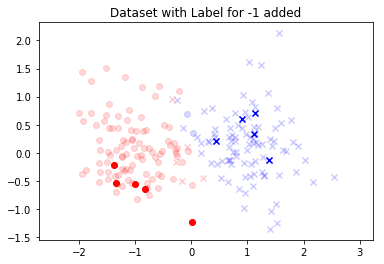

(1, 200)
Time for EEM = 0.205819
Iter = 1


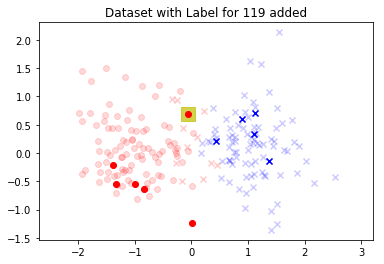

(1, 200)
Time for EEM = 0.180555
Iter = 2


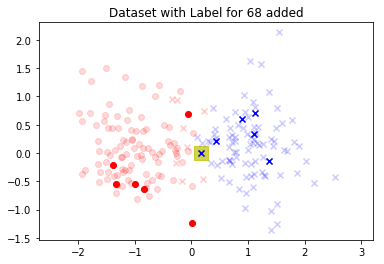

(1, 200)
Time for EEM = 0.187748
Iter = 3


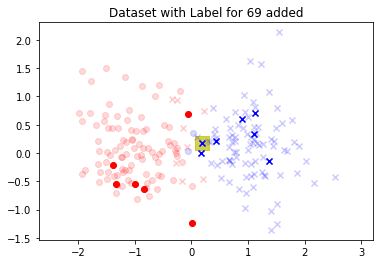

(1, 200)
Time for EEM = 0.210614
Iter = 4


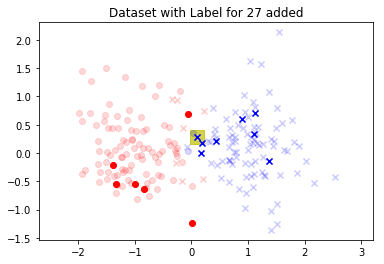

(1, 200)
Time for EEM = 0.186068
Iter = 5


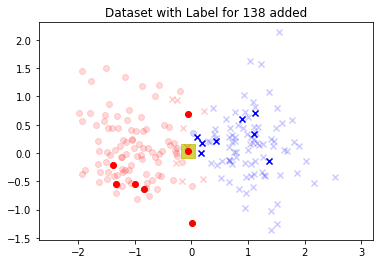

(1, 200)
Time for EEM = 0.183373
Iter = 6


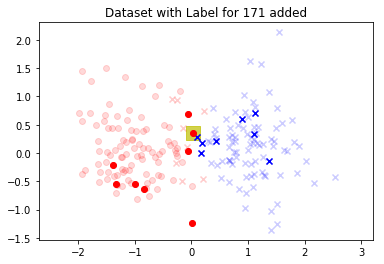

(1, 200)
Time for EEM = 0.184766
Iter = 7


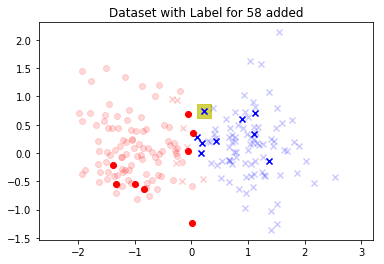

(1, 200)
Time for EEM = 0.190296
Iter = 8


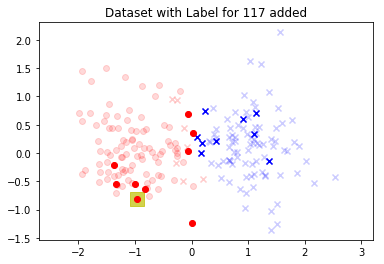

(1, 200)
Time for EEM = 0.183881
Iter = 9


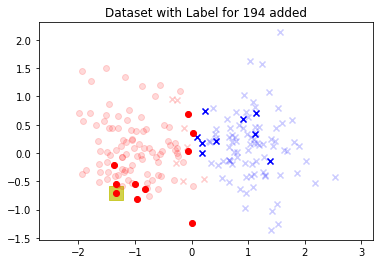

(1, 200)
Time for EEM = 0.175572
Iter = 10


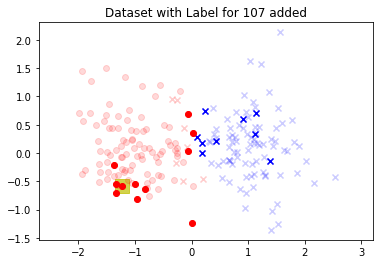

(1, 200)
Time for EEM = 0.176020
Iter = 11


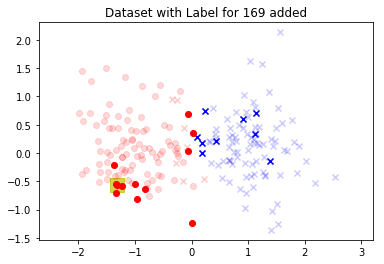

(1, 200)
Time for EEM = 0.175285
Iter = 12


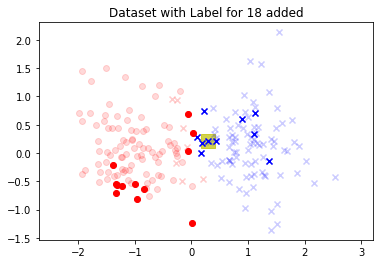

(1, 200)
Time for EEM = 0.195979
Iter = 13


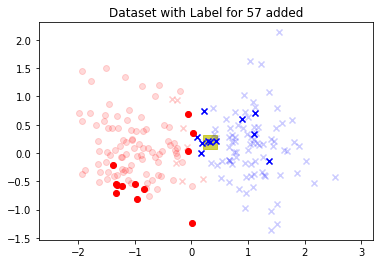

(1, 200)
Time for EEM = 0.204090
Iter = 14


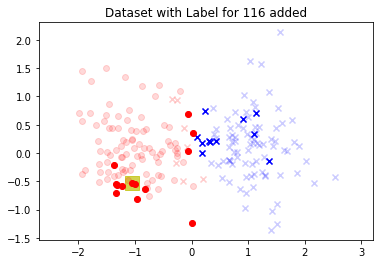

(1, 200)
Time for EEM = 0.162544
Iter = 15


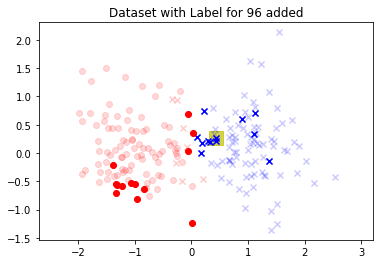

(1, 200)
Time for EEM = 0.169336
Iter = 16


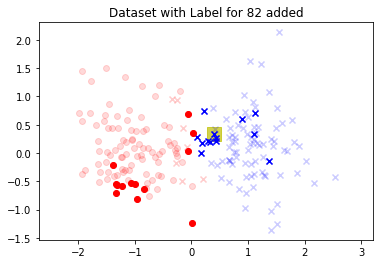

(1, 200)
Time for EEM = 0.156007
Iter = 17


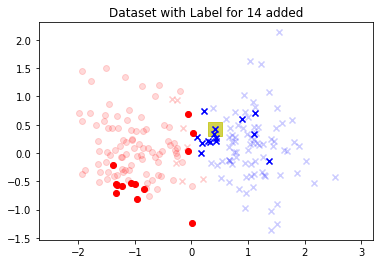

(1, 200)
Time for EEM = 0.152264
Iter = 18


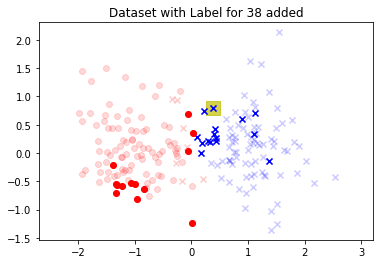

(1, 200)
Time for EEM = 0.153809
Iter = 19


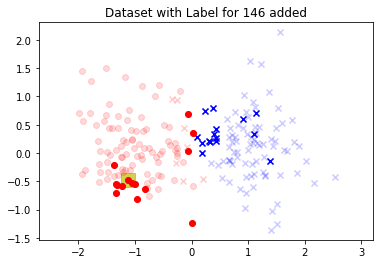

(1, 200)
Time for EEM = 0.156917
Iter = 20


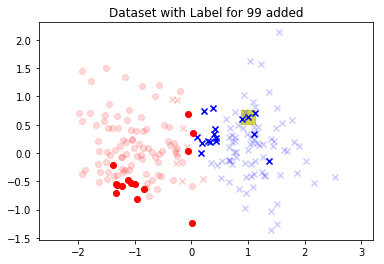

[(-1, 0.035), (119, 0.055), (68, 0.04), (69, 0.05), (27, 0.045), (138, 0.045), (171, 0.04), (58, 0.035), (117, 0.035), (194, 0.035), (107, 0.035), (169, 0.035), (18, 0.035), (57, 0.035), (116, 0.035), (96, 0.035), (82, 0.035), (14, 0.035), (38, 0.035), (146, 0.035), (99, 0.035)]


In [53]:
# Active Learning
fid = copy.deepcopy(fid_orig)
tag2 = (tau, alpha, gamma2)
test_opts = (num_iters, True)
ERRS, M = run_test_AL(X, v, w, fid, ground_truth, tag2, test_opts)

if verbose:
    print(ERRS)

## Compare to Random Sampling

In [ ]:
fid = copy.deepcopy(fid_orig)
tag2 = (tau, alpha, gamma2)
test_opts = (num_iters, False)
ERRS_rand, M_rand = run_test_rand(X, v, w, fid, ground_truth, tag2, test_opts)

if verbose:
    print(ERRS_rand)

## Convergence Comparison

In [ ]:
ids_al, errs = zip(*ERRS)
ids_rand, errs_rand = zip(*ERRS_rand)
plt.plot(range(num_iters+1), errs, 'b--', label='AL')
plt.plot(range(num_iters+1), errs_rand, 'g', label='random')
plt.title('Convergence Plot')
plt.legend()
plt.show()

# Analyzing solution $\mathbf{m}$

In [ ]:
m = M[0]

lin = [i for i in range(N)]
print(m.shape)
print(len(lin))
plt.scatter(lin, list(m), marker='.')
plt.plot(lin, N*[0.], 'r--', linewidth=1.5)
plt.show()

In [ ]:
for l in range(5):
    if l % 3 == 0:
        m = list(M[l])
        lin = [i for i in range(N)]
        plt.scatter(lin, m, marker='.')
        plt.plot(lin, N*[0.], 'r--', linewidth=1.5)
        plt.title('Iter = %d' % l)
        plt.show()

In [ ]:
m = M[0]
m_new = m.copy()
m_new[m_new > 1.] = 1.
m_new[m_new < -1.] = -1.


In [ ]:
def E(x):
    vTx = v.T.dot(x.T)
    wvTx = np.diag(w).dot(vTx)
    val = vTx.T.dot(wvTx)
    return  val + (1./gamma**2)*np.linalg.norm(B.dot(x.T).flatten() - y)**2.

In [ ]:
B_diag = np.zeros(N)
labeled = set()
for k in fid_orig.keys():
    labeled = labeled.union(set(fid_orig[k]))
labeled = list(labeled)
B_diag[labeled] = 1.
B = sp.sparse.diags(B_diag, format='lil')
m, C, y = calc_orig(v, w, B, fid, tau, alpha, gamma2)

E_m = E(m)
E_m_new = E(m_new)

In [ ]:
print(E_m, E_m_new)

# 2 Moons Example


Functions in this section are defined in the ``util.py`` helper file with names like ``*2``, ``*2AL``, etc.

In [27]:
from sklearn.datasets import make_moons

In [ ]:
# Setup
N = 1000
data = make_moons(N, noise=0.15)

X, ground_truth = data
X1, X2 = X[ground_truth == 0,:], X[ground_truth == 1,:] 
ground_truth[np.where(ground_truth == 0)] = -1

#plt.rcParams['figure.figsize'] =(6,6)
plt.scatter(X1[:,0], X1[:,1], c='r')
plt.scatter(X2[:,0], X2[:,1], c='b')
plt.title('Two Moons dataset')
plt.show()



# Define the labeled and unlabed indices
sup_percent = 0.1
indices = np.array(list(range(N)))
labeled_orig = set()
fid_orig = {}
gt_flipped = {}
for i in [-1,1]:
    i_mask = indices[ground_truth ==i]
    gt_flipped[i] = i_mask
    np.random.shuffle(i_mask)
    n_i = len(i_mask)
    fid_orig[i] = list(i_mask[:int(sup_percent*n_i)])
    labeled_orig = labeled_orig.union(set(fid_orig[i]))
unlabeled_orig = sorted(list(set(indices) - labeled_orig))
labeled_orig = sorted(list(labeled_orig))


# Graph Generation and Eigen-Calculation
W = make_sim_graph(X)
w,v = get_eig_Lnorm(W)


# Model Setup
tau, alpha, gamma = 0.001, 1.0, 0.0001
gamma2 = gamma**2.
verbose = True     # set to True if want to see visual of which points chosen
num_iters = 5

In [ ]:
# Active Learning Choices -- EEM 
fid = copy.deepcopy(fid_orig)
tag2 = (tau, alpha, gamma2)
test_opts = (num_iters, verbose)
ERRS, M = run_test_AL(X, v, w, fid, ground_truth, tag2, test_opts)

if verbose:
    print(ERRS)

In [ ]:
# Random choice
labeled = labeled_orig.copy()
unlabeled = unlabeled_orig.copy()
fid = copy.deepcopy(fid_orig)

ERRS_rand, M_rand = run_test_rand(X, v, w, fid, ground_truth, tag2, test_opts)
if verbose:
    print(ERRS_rand)

## Error Plotting - 2 Moons 

In [ ]:
colors = ['y', 'r', 'k', 'g']
ids, errs = zip(*ERRS)
ids_rand, errs_rand = zip(*ERRS_rand)
plt.figure()
plt.plot([i for i in range(num_iters+1)], errs, 'b--', label='AL')
plt.plot([i for i in range(num_iters+1)], errs_rand, 'g-o', label='rand')
test_opts = (num_iters, False)
for i in range(4):
    labeled = labeled_orig.copy()
    unlabeled = unlabeled_orig.copy()
    fid = copy.deepcopy(fid_orig)

    ERRS_rand, M_rand = run_test_rand(X, v, w, fid, ground_truth, tag2, test_opts)
    ids_rand, errs_rand = zip(*ERRS_rand)
    plt.plot([i for i in range(num_iters+1)], errs_rand,'%so-'%colors[i], label='rand')
plt.legend()


# Faster Approximations

We can calculate $\mathbf{m}|_u$ faster with using the derivation given in Rasmussen's Gaussian Process book. 

$$
    \mathbf{m}_u = C_\tau^{u \ell} \left( \gamma^2 I  + C_\tau^{\ell \ell}\right)^{-1}\mathbf{y}
$$

Where $C_\tau^{u \ell}, C_\tau^{\ell \ell}$ are the submatrices of $C_\tau = \tau^{2\alpha}(L + \tau^2 I)^{-alpha}$ corresponding to the ``unlabeled`` ($u$) and ``labeled`` ($\ell$) indices.

Could also do the matrix multiplication

$$ 
    \mathbf{m} = \begin{bmatrix}
                C_\tau^{\ell \ell} \\
                C_\tau^{u \ell} \\
                \end{bmatrix} \left( \gamma^2 I  + C_\tau^{\ell \ell}\right)^{-1}\mathbf{y}.
$$
to obtain $\mathbf{m}$ on all the indices.


In [ ]:
# Problem Setup --- Need to rework this example to be more general. I've made it so that the clusters are 
# in consecutive order for plotting m (0-99, 100-199). For this I had to re write the helper functions when 
# doing the Two moons dataset.

Ns = [1000,1000]
N = sum(Ns)
fs = 50
means = [np.array([1.0,0.]), np.array([-1.0,0.])]
Covs = [0.3*np.eye(2), 0.3*np.eye(2)]

# define fidelity and ground truth 
fid_orig = {}
fid_orig[1] = list(range(fs))
fid_orig[-1] = [Ns[0] + i for i in range(fs)]
ground_truth = np.array([1. if i<Ns[0] else -1. for i in range(N)])


# Graph computations
X, W = generate_data_graphs(Ns, means, Covs)
w,v = get_eig_Lnorm(W)

# Model Setup
tau, alpha, gamma = 0.001, 1.0, 0.0001
gamma2 = gamma**2.
verbose = True     # set to True if want to see visual of which points chosen
num_iters = 20


# Plot the data set
plt.rcParams['figure.figsize'] = (6,4)
plt.scatter(X[:Ns[0],0], X[:Ns[0],1], marker='x', c='b', alpha=0.8)
plt.scatter(X[Ns[0]:,0], X[Ns[0]:,1], marker='o', c='r',alpha=0.8)
plt.axis('equal')
plt.title('Gaussian Clusters data - Ground Truth')
plt.show()

In [ ]:
# Other Approximation for finding m restricted to the unlabeled set
labeled = set()
indices = np.array(list(range(N)))
for k in fid.keys():
    k_mask = indices[ground_truth ==k]
    gt_flipped[k] = k_mask
    labeled = labeled.union(set(fid[k]))
unlabeled = sorted(list(set(indices) - labeled))
labeled = sorted(list(labeled)) 

# Initial solution - find m and C, keep track of y
B_diag = np.zeros(N)
B_diag[labeled] = 1.
B = sp.sparse.diags(B_diag, format='lil')

m, C, y = calc_orig(v, w, B, fid, tau, alpha, gamma2)

In [ ]:
# only m_u
tic = time.clock()
w_inv = (tau ** (2 * alpha)) * np.power(w + tau**2., -alpha)     # diagonalization of C_t,e
v_lab = v[labeled,:]   # get the rows of v corresponding to labeled points
w_inv_v_lab = (v_lab*w_inv).T
C_ul = v[unlabeled,:].dot(w_inv_v_lab)
A = v_lab.dot(w_inv_v_lab)
A[np.diag_indices(N_prime)] += gamma2
A_inv = sla.inv(A)
m_u = C_ul.dot(A_inv.dot(y[labeled]))
toc = time.clock()
print(toc - tic)

In [ ]:
print(np.allclose(m_u, m[0,unlabeled]))

In [ ]:
# all of m
tic = time.clock()
w_inv = (tau ** (2 * alpha)) * np.power(w + tau**2., -alpha)     # diagonalization of C_t,e
v_lab = v[labeled,:]   # get the rows of v corresponding to labeled points
#v_unlab = v[unlabeled,:]
w_inv_v_lab = (v_lab*w_inv).T
C_all_l = v.dot(w_inv_v_lab)
A = v_lab.dot(w_inv_v_lab)
A[np.diag_indices(N_prime)] += gamma2
A_inv = sla.inv(A)
m_all = C_all_l.dot(A_inv.dot(y[labeled]))
toc = time.clock()
print(toc - tic)

In [ ]:
print(np.allclose(m, m_all))

In [ ]:
# the calculation in the code currently
tic = time.clock()
d = (tau ** (2 * alpha)) * np.power(w + tau**2., -alpha)     # diagonalization of C_t,e
# prior_inv : C_{tau,eps}^{-1}, where
# C_{tau, eps}^{-1} = tau^{-2alpha}(L + tau^2 I)^alpha
prior_inv = v.dot(sp.sparse.diags([1./thing for thing in d], format='lil').dot(v.T))
# B/gamma^2
B_over_gamma2 = B / (gamma2)
# post_inv  : (B/gamma^2 + C_{tau,\eps}^{-1})^{-1}
post_inv  = prior_inv + B_over_gamma2
C = post_inv.I
m_comp = (1./gamma2)*C.dot(y).flatten()
toc = time.clock()
print(toc - tic)

In [ ]:
print(np.allclose(m_comp, m_all)) # check that it still calculates correctly...

## Observations 

This seems to scale much better than previous calculation. Now, we look to calculating $C$ as well, since that is needed for our sampling and future updating with t


Calculating $C$ then is found by just applying Woodbury identity on our normal expression for $C$:
$$
\begin{align}
    C &= \left(C_\tau^{-1} + \frac{1}{\gamma^2}B\right)^{-1} \\
    &= C_\tau - C_\tau H^T \left(\gamma^2 I + H C_\tau H^T \right)^{-1}HC_\tau \\
    &= C_\tau - C_\tau^{:,\ell}\left(\gamma^2 I + H C_\tau H^T \right)^{-1}C_\tau^{\ell, :} \\
\end{align}
$$

This is a little more costly than just the update to $\mathbf{m}$ because of the need to explicitly calculate $C_\tau$, but it's still faster I believe.

In [ ]:
# all of m and C...
tic = time.clock()
w_inv = (tau ** (2 * alpha)) * np.power(w + tau**2., -alpha)     # diagonalization of C_t,e
C_tau = v.dot((v*w_inv).T)
C_ll = C_tau[np.ix_(labeled, labeled)]
C_all_l = C_tau[:,labeled]
C_ll[np.diag_indices(N_prime)] += gamma2  # directly changing C_ll
A_inv = sla.inv(C_ll)
Block1 = C_all_l.dot(A_inv)
C2 = C_tau - Block1.dot(C_all_l.T)
m_all2 = Block1.dot(y[labeled])
toc = time.clock()
print(toc - tic)

In [ ]:
print(np.allclose(m_all2, m))
print(np.allclose(C2, C))

# Search Space Reduction Heuristic

It seems that many methods (e.g. V-Opt, $\Sigma$-Opt, GRF-H EEM, SLS, etc) take on the order of $\mathcal{O}(N^2)$ calculations to find an optimal query point (or set of query points). This is because we often have to calculate some objective function that *for each unobserved point* requires a calcuation *over every point in the dataset*. Since we usually have the $N' \ll N$, then the number of unobserved points we need to do the calculation for still remains on the order of $\mathcal{O}(N)$.

However, searching over *all* unobserved data points is extraneous oftentimes, since we really want to look at just the more "informative" points which often includes those points on the optimal decision boundary. Our heuristic is to use the classification of an initial iteration of a given algorithm (e.g. *GL*, *Probit*, *BPC*) to define a *cut* of the dataset's underlying similarity graph. Using this cut, we obtain a surrogate decision boundary that hopefully approximates or includes similar nodes that the optimal decision boundary would have; as this "cut set" $S$ of nodes should be much smaller than the total number of unobserved data points in the data set (that is  $S \ll N - N'$), we should be able to reduce the order of the problem to something more manageable.


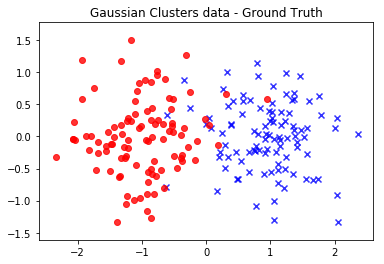

In [2]:
# Problem Setup --- Need to rework this example to be more general. I've made it so that the clusters are 
# in consecutive order for plotting m (0-99, 100-199). For this I had to re write the helper functions when 
# doing the Two moons dataset.

Ns = [100,100]
N = sum(Ns)
fs = 5
means = [np.array([1.0,0.]), np.array([-1.0,0.])]
Covs = [0.3*np.eye(2), 0.3*np.eye(2)]

# define fidelity and ground truth 
fid_orig = {}
fid_orig[1] = list(range(fs))
fid_orig[-1] = [Ns[0] + i for i in range(fs)]
ground_truth = np.array([1. if i<Ns[0] else -1. for i in range(N)])


# Graph computations
X, W = generate_data_graphs(Ns, means, Covs)
w,v = get_eig_Lnorm(W)

# Model Setup
tau, alpha, gamma = 0.001, 1.0, 0.0001
gamma2 = gamma**2.
verbose = True     # set to True if want to see visual of which points chosen
num_iters = 20


# Plot the data set
plt.rcParams['figure.figsize'] = (6,4)
plt.scatter(X[:Ns[0],0], X[:Ns[0],1], marker='x', c='b', alpha=0.8)
plt.scatter(X[Ns[0]:,0], X[Ns[0]:,1], marker='o', c='r',alpha=0.8)
plt.axis('equal')
plt.title('Gaussian Clusters data - Ground Truth')
plt.show()

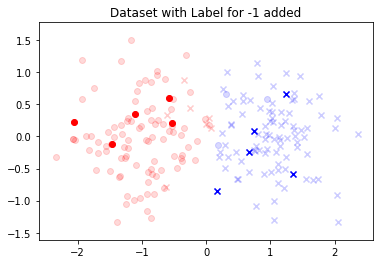

In [4]:
# Other Approximation for finding m restricted to the unlabeled set
fid = copy.deepcopy(fid_orig)
labeled = set()
gt_flipped = {}
indices = np.array(list(range(N)))
for k in fid.keys():
    k_mask = indices[ground_truth ==k]
    gt_flipped[k] = k_mask
    labeled = labeled.union(set(fid[k]))
unlabeled = sorted(list(set(indices) - labeled))
labeled = sorted(list(labeled)) 

# Initial solution - find m and C, keep track of y
B_diag = np.zeros(N)
B_diag[labeled] = 1.
B = sp.sparse.diags(B_diag, format='lil')


# Get our initial estimate, via BPC method
m, C, y = calc_orig_new(v, w, B, fid, labeled, unlabeled, tau, alpha, gamma2)
error, stats_obj = calc_stats(m, fid, gt_flipped)
plot_iter(stats_obj, X)

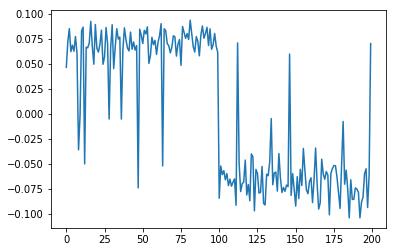

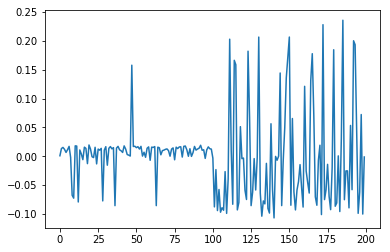

In [5]:
v1 = v[:,1]
v2 = v[:,2]
plt.plot([i for i in range(N)], v1)
plt.show()
plt.plot([i for i in range(N)], v2)
plt.show()

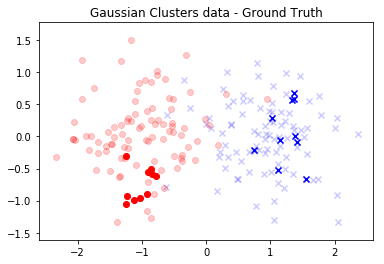

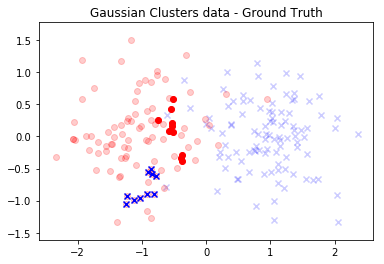

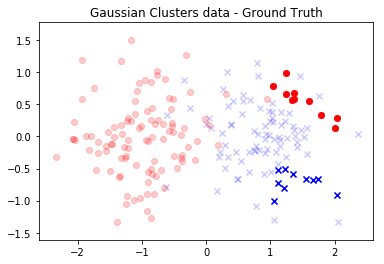

In [11]:
ind_max = (-v1).argsort()[:10]
ind_min = (v1).argsort()[:10]
# Plot the data set
plt.rcParams['figure.figsize'] = (6,4)
plt.scatter(X[:Ns[0],0], X[:Ns[0],1], marker='x', c='b', alpha=0.2)
plt.scatter(X[Ns[0]:,0], X[Ns[0]:,1], marker='o', c='r',alpha=0.2)
plt.scatter(X[ind_max,0], X[ind_max,1], marker='x', c='b', alpha=1.0)
plt.scatter(X[ind_min,0], X[ind_min,1], marker='o', c='r',alpha=1.0)
plt.axis('equal')
plt.title('Gaussian Clusters data - Ground Truth')
plt.show()

ind_max = (-v2).argsort()[:10]
ind_min = (v2).argsort()[:10]
# Plot the data set
plt.rcParams['figure.figsize'] = (6,4)
plt.scatter(X[:Ns[0],0], X[:Ns[0],1], marker='x', c='b', alpha=0.2)
plt.scatter(X[Ns[0]:,0], X[Ns[0]:,1], marker='o', c='r',alpha=0.2)
plt.scatter(X[ind_max,0], X[ind_max,1], marker='x', c='b', alpha=1.0)
plt.scatter(X[ind_min,0], X[ind_min,1], marker='o', c='r',alpha=1.0)
plt.axis('equal')
plt.title('Gaussian Clusters data - Ground Truth')
plt.show()


ind_max = (-v3).argsort()[:10]
ind_min = (v3).argsort()[:10]
# Plot the data set
plt.rcParams['figure.figsize'] = (6,4)
plt.scatter(X[:Ns[0],0], X[:Ns[0],1], marker='x', c='b', alpha=0.2)
plt.scatter(X[Ns[0]:,0], X[Ns[0]:,1], marker='o', c='r',alpha=0.2)
plt.scatter(X[ind_max,0], X[ind_max,1], marker='x', c='b', alpha=1.0)
plt.scatter(X[ind_min,0], X[ind_min,1], marker='o', c='r',alpha=1.0)
plt.axis('equal')
plt.title('Gaussian Clusters data - Ground Truth')
plt.show()

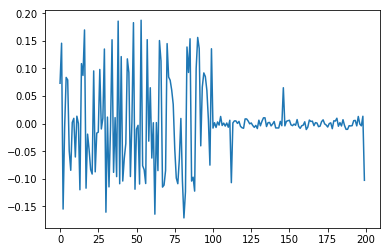

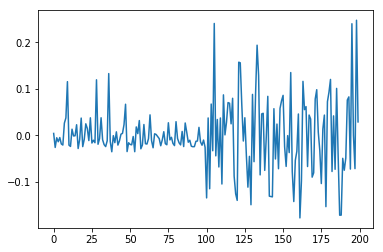

In [6]:
v3 = v[:,3]
v4 = v[:,4]
plt.plot([i for i in range(N)], v3)
plt.show()
plt.plot([i for i in range(N)], v4)
plt.show()

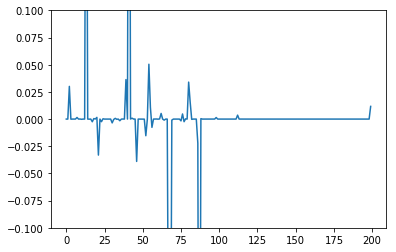

1.660076784676261 2.0452957199783824e-16


In [15]:

print(w[-1], w[0])

In [17]:
L = v.dot((v*w).T)
print(v_last.T.dot(L.dot(v_last)))

1.6600767846762614


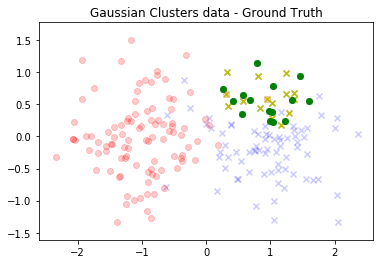

In [23]:
v_last = v[:,-1]
plt.plot([i for i in range(N)], v_last)
plt.ylim(-0.1,0.1)
plt.show()
ind_max = (-v_last).argsort()[:15]
ind_min = (v_last).argsort()[:15]
# Plot the data set
plt.rcParams['figure.figsize'] = (6,4)
plt.scatter(X[:Ns[0],0], X[:Ns[0],1], marker='x', c='b', alpha=0.2)
plt.scatter(X[Ns[0]:,0], X[Ns[0]:,1], marker='o', c='r',alpha=0.2)
plt.scatter(X[ind_max,0], X[ind_max,1], marker='x', c='y', alpha=1.0)
plt.scatter(X[ind_min,0], X[ind_min,1], marker='o', c='g',alpha=1.0)
plt.axis('equal')
plt.title('Gaussian Clusters data - Ground Truth')
plt.show()


v_last2 = v[:,-2]
plt.plot([i for i in range(N)], v_last2)
plt.ylim(-0.1,0.1)
plt.show()
ind_max = (-v_last2).argsort()[:5]
ind_min = (v_last2).argsort()[:5]
# Plot the data set
plt.rcParams['figure.figsize'] = (6,4)
plt.scatter(X[:Ns[0],0], X[:Ns[0],1], marker='x', c='b', alpha=0.2)
plt.scatter(X[Ns[0]:,0], X[Ns[0]:,1], marker='o', c='r',alpha=0.2)
plt.scatter(X[ind_max,0], X[ind_max,1], marker='x', c='y', alpha=1.0)
plt.scatter(X[ind_min,0], X[ind_min,1], marker='o', c='g',alpha=1.0)
plt.axis('equal')
plt.title('Gaussian Clusters data - Ground Truth')
plt.show()



v_last3 = v[:,-3]
plt.plot([i for i in range(N)], v_last3)
plt.ylim(-0.1,0.1)
plt.show()
ind_max = (-v_last3).argsort()[:5]
ind_min = (v_last3).argsort()[:5]
# Plot the data set
plt.rcParams['figure.figsize'] = (6,4)
plt.scatter(X[:Ns[0],0], X[:Ns[0],1], marker='x', c='b', alpha=0.2)
plt.scatter(X[Ns[0]:,0], X[Ns[0]:,1], marker='o', c='r',alpha=0.2)
plt.scatter(X[ind_max,0], X[ind_max,1], marker='x', c='y', alpha=1.0)
plt.scatter(X[ind_min,0], X[ind_min,1], marker='o', c='g',alpha=1.0)
plt.axis('equal')
plt.title('Gaussian Clusters data - Ground Truth')
plt.show()


v_last4 = v[:,-4]
plt.plot([i for i in range(N)], v_last4)
plt.ylim(-0.1,0.1)
plt.show()
ind_max = (-v_last4).argsort()[:5]
ind_min = (v_last4).argsort()[:5]
# Plot the data set
plt.rcParams['figure.figsize'] = (6,4)
plt.scatter(X[:Ns[0],0], X[:Ns[0],1], marker='x', c='b', alpha=0.2)
plt.scatter(X[Ns[0]:,0], X[Ns[0]:,1], marker='o', c='r',alpha=0.2)
plt.scatter(X[ind_max,0], X[ind_max,1], marker='x', c='y', alpha=1.0)
plt.scatter(X[ind_min,0], X[ind_min,1], marker='o', c='g',alpha=1.0)
plt.axis('equal')
plt.title('Gaussian Clusters data - Ground Truth')
plt.show()

In [26]:
print(w[-5:])

[1.60212174 1.63201021 1.63554705 1.64903482 1.66007678]


In [123]:
calc_clusters = {}
calc_clusters[1] = np.where(m >= 0)[1]
calc_clusters[-1] = np.where(m < 0)[1]
c1_ind, c2_ind = W[np.ix_(calc_clusters[1], calc_clusters[-1])].nonzero()

In [124]:
search_nodes = set(calc_clusters[1][c1_ind]).union(set(calc_clusters[-1][c2_ind]))
print(search_nodes)

{64, 198, 71, 78, 142, 143, 144, 147, 152, 32, 161, 169, 109, 112, 114, 118, 56, 121, 123, 189, 127}


In [129]:
fid = copy.deepcopy(fid_orig)
tag2 = (tau, alpha, gamma2)
test_opts = (10, False)
ERRS, M = run_test_AL(X, v, w, fid, ground_truth, tag2, test_opts)

In [130]:
print(fid)
print(fid_orig)

chosen_nodes = set([])
chosen_nodes = chosen_nodes.union(set(fid[1]) - set(fid_orig[1]))

chosen_nodes = chosen_nodes.union(set(fid[-1]) - set(fid_orig[-1]))

print(search_nodes)
print(chosen_nodes)
print(search_nodes.intersection(chosen_nodes))

{1: [0, 1, 2, 3, 4, 24, 33, 9, 90, 98, 78], -1: [100, 101, 102, 103, 104, 123, 178, 167, 109]}
{1: [0, 1, 2, 3, 4], -1: [100, 101, 102, 103, 104]}
{64, 198, 71, 78, 142, 143, 144, 147, 152, 32, 161, 169, 109, 112, 114, 118, 56, 121, 123, 189, 127}
{33, 98, 167, 9, 109, 78, 178, 24, 90, 123}
{123, 109, 78}


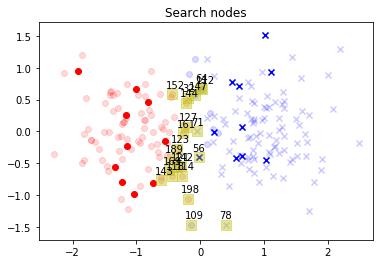

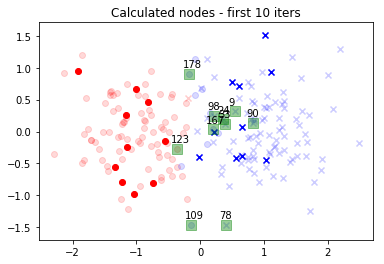

In [131]:
corr1 = stats_obj['corr1']
corr2 = stats_obj['corr2']
sup1 = stats_obj['sup1']
sup2 = stats_obj['sup2']
incorr1 = stats_obj['incorr1']
incorr2 = stats_obj['incorr2']

plt.scatter(X[corr1,0], X[corr1,1], marker='x', c='b', alpha=0.2)
plt.scatter(X[incorr1,0], X[incorr1,1], marker='x', c='r', alpha=0.2)
plt.scatter(X[corr2,0], X[corr2,1], marker='o', c='r',alpha=0.15)
plt.scatter(X[incorr2,0], X[incorr2,1], marker='o', c='b',alpha=0.15)
plt.scatter(X[sup1,0], X[sup1,1], marker='x', c='b', alpha=1.0)
plt.scatter(X[sup2,0], X[sup2,1], marker='o', c='r', alpha=1.0)

for s in search_nodes:
    plt.scatter(X[s,0], X[s,1], marker= 's', c='y', alpha= 0.4, s=100) # plot the new point to be included
    plt.annotate(r'%d' % s, (X[s,0], X[s,1]), xytext=(X[s,0]-0.1, X[s,1] + 0.1))
plt.axis('equal')

plt.title('Search nodes')
plt.show()

plt.scatter(X[corr1,0], X[corr1,1], marker='x', c='b', alpha=0.2)
plt.scatter(X[incorr1,0], X[incorr1,1], marker='x', c='r', alpha=0.2)
plt.scatter(X[corr2,0], X[corr2,1], marker='o', c='r',alpha=0.15)
plt.scatter(X[incorr2,0], X[incorr2,1], marker='o', c='b',alpha=0.15)
plt.scatter(X[sup1,0], X[sup1,1], marker='x', c='b', alpha=1.0)
plt.scatter(X[sup2,0], X[sup2,1], marker='o', c='r', alpha=1.0)

for c in chosen_nodes:
    plt.scatter(X[c,0], X[c,1], marker= 's', c='g', alpha= 0.4, s=100) # plot the new point to be included
    plt.annotate(r'%d' % c, (X[c,0], X[c,1]), xytext=(X[c,0]-0.1, X[c,1] + 0.1))
plt.axis('equal')

plt.title('Calculated nodes - first 10 iters')
plt.show()

## Observations

I wonder if even just randomly sampling (or sampling *all* the cut node set $S$ would be good? It would be super fast... but I'm guessing it will restrict very quickly and level off at some accuracy.

Maybe also, another idea is to have a chosing mechanism that varies between exploration and exploitation to preserve the diversity in the sample space. Like a Bernoulli r.v. to either choose between the decision boundary cut set $S$ or a random node in the data set (or some other criterion that is more general than the cut set)?

In [28]:
def compute_laplacian(W):
    D = sp.sparse.diags(np.sum(W, axis=0).getA().flatten())
    L = D - W
    return L, D.diagonal()

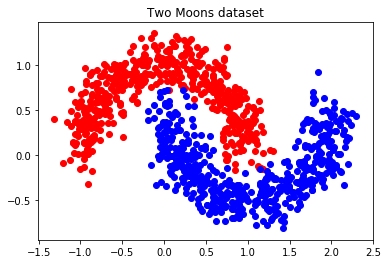

In [29]:
# Setup
N = 1000
data = make_moons(N, noise=0.15)

X, ground_truth = data
X1, X2 = X[ground_truth == 0,:], X[ground_truth == 1,:] 
ground_truth[np.where(ground_truth == 0)] = -1

#plt.rcParams['figure.figsize'] =(6,6)
plt.scatter(X1[:,0], X1[:,1], c='r')
plt.scatter(X2[:,0], X2[:,1], c='b')
plt.title('Two Moons dataset')
plt.show()



# Define the labeled and unlabed indices
sup_percent = 0.1
indices = np.array(list(range(N)))
labeled_orig = set()
fid_orig = {}
gt_flipped = {}
for i in [-1,1]:
    i_mask = indices[ground_truth ==i]
    gt_flipped[i] = i_mask
    np.random.shuffle(i_mask)
    n_i = len(i_mask)
    fid_orig[i] = list(i_mask[:int(sup_percent*n_i)])
    labeled_orig = labeled_orig.union(set(fid_orig[i]))
unlabeled_orig = sorted(list(set(indices) - labeled_orig))
labeled_orig = sorted(list(labeled_orig))


# Graph Generation and Eigen-Calculation
W = make_sim_graph(X)
w,v = get_eig_Lnorm(W)


# Model Setup
tau, alpha, gamma = 0.001, 1.0, 0.0001
gamma2 = gamma**2.
verbose = True     # set to True if want to see visual of which points chosen
num_iters = 5

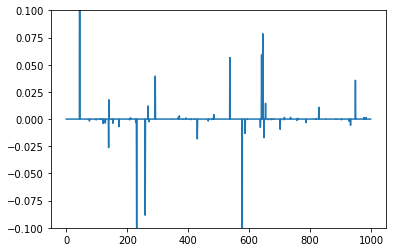

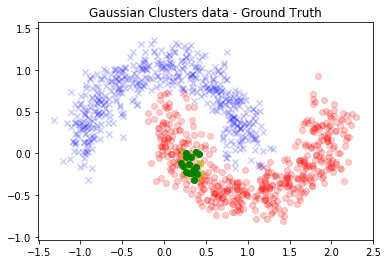

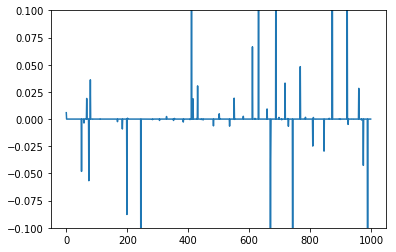

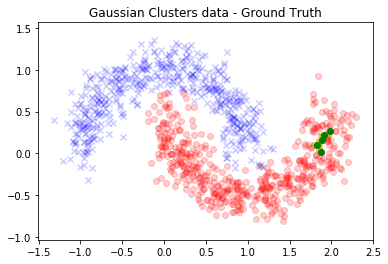

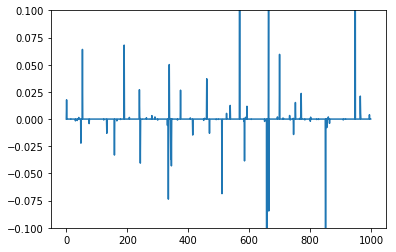

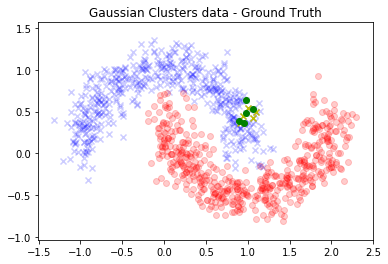

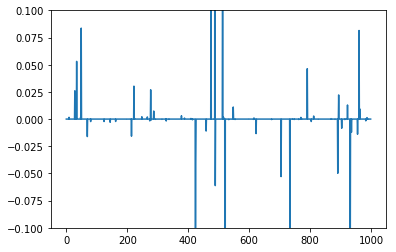

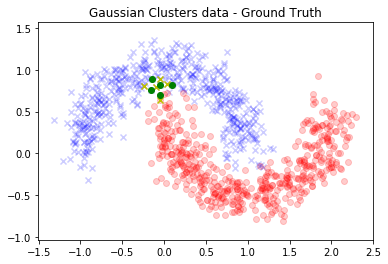

In [31]:
# normalized graph Laplacian
v_last = v[:,-1]
plt.plot([i for i in range(N)], v_last)
plt.ylim(-0.1,0.1)
plt.show()
ind_max = (-v_last).argsort()[:15]
ind_min = (v_last).argsort()[:15]
# Plot the data set
plt.rcParams['figure.figsize'] = (6,4)
plt.scatter(X1[:,0], X1[:,1], marker='x', c='b', alpha=0.2)
plt.scatter(X2[:,0], X2[:,1], marker='o', c='r',alpha=0.2)
plt.scatter(X[ind_max,0], X[ind_max,1], marker='x', c='y', alpha=1.0)
plt.scatter(X[ind_min,0], X[ind_min,1], marker='o', c='g',alpha=1.0)
plt.axis('equal')
plt.title('Gaussian Clusters data - Ground Truth')
plt.show()


v_last2 = v[:,-2]
plt.plot([i for i in range(N)], v_last2)
plt.ylim(-0.1,0.1)
plt.show()
ind_max = (-v_last2).argsort()[:5]
ind_min = (v_last2).argsort()[:5]
# Plot the data set
plt.rcParams['figure.figsize'] = (6,4)
plt.scatter(X1[:,0], X1[:,1], marker='x', c='b', alpha=0.2)
plt.scatter(X2[:,0], X2[:,1], marker='o', c='r',alpha=0.2)
plt.scatter(X[ind_max,0], X[ind_max,1], marker='x', c='y', alpha=1.0)
plt.scatter(X[ind_min,0], X[ind_min,1], marker='o', c='g',alpha=1.0)
plt.axis('equal')
plt.title('Gaussian Clusters data - Ground Truth')
plt.show()



v_last3 = v[:,-3]
plt.plot([i for i in range(N)], v_last3)
plt.ylim(-0.1,0.1)
plt.show()
ind_max = (-v_last3).argsort()[:5]
ind_min = (v_last3).argsort()[:5]
# Plot the data set
plt.rcParams['figure.figsize'] = (6,4)
plt.scatter(X1[:,0], X1[:,1], marker='x', c='b', alpha=0.2)
plt.scatter(X2[:,0], X2[:,1], marker='o', c='r',alpha=0.2)
plt.scatter(X[ind_max,0], X[ind_max,1], marker='x', c='y', alpha=1.0)
plt.scatter(X[ind_min,0], X[ind_min,1], marker='o', c='g',alpha=1.0)
plt.axis('equal')
plt.title('Gaussian Clusters data - Ground Truth')
plt.show()


v_last4 = v[:,-4]
plt.plot([i for i in range(N)], v_last4)
plt.ylim(-0.1,0.1)
plt.show()
ind_max = (-v_last4).argsort()[:5]
ind_min = (v_last4).argsort()[:5]
# Plot the data set
plt.rcParams['figure.figsize'] = (6,4)
plt.scatter(X1[:,0], X1[:,1], marker='x', c='b', alpha=0.2)
plt.scatter(X2[:,0], X2[:,1], marker='o', c='r',alpha=0.2)
plt.scatter(X[ind_max,0], X[ind_max,1], marker='x', c='y', alpha=1.0)
plt.scatter(X[ind_min,0], X[ind_min,1], marker='o', c='g',alpha=1.0)
plt.axis('equal')
plt.title('Gaussian Clusters data - Ground Truth')
plt.show()

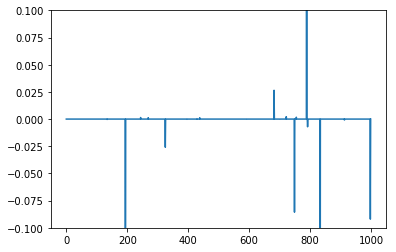

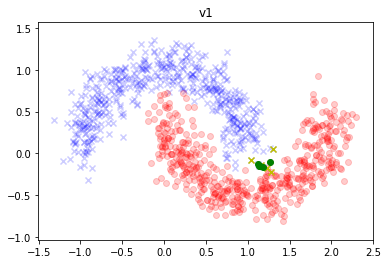

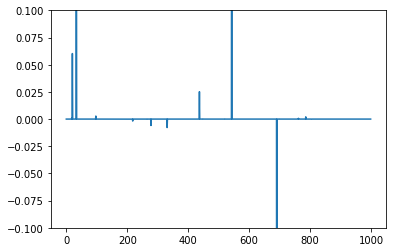

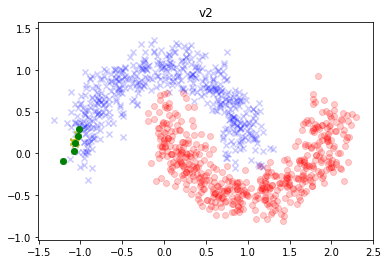

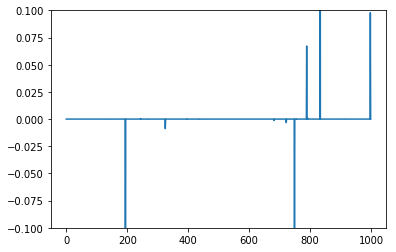

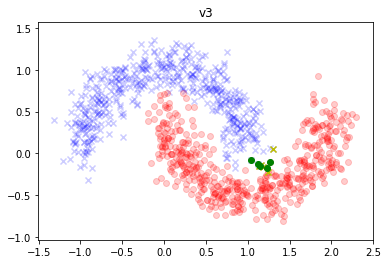

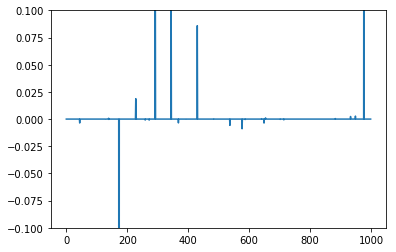

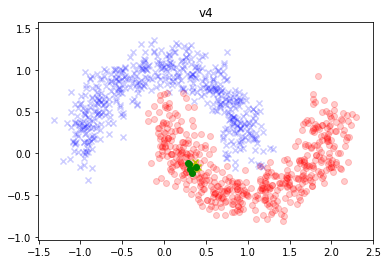

In [39]:
# unnormalized graph Laplacian
L_u, D_u = compute_laplacian(W)
w,v = sp.linalg.eigh(L_u.toarray())
v_last = v[:,-1]
plt.plot([i for i in range(N)], v_last)
plt.ylim(-0.1,0.1)
plt.show()
ind_max = (-v_last).argsort()[:5]
ind_min = (v_last).argsort()[:5]
# Plot the data set
plt.rcParams['figure.figsize'] = (6,4)
plt.scatter(X1[:,0], X1[:,1], marker='x', c='b', alpha=0.2)
plt.scatter(X2[:,0], X2[:,1], marker='o', c='r',alpha=0.2)
plt.scatter(X[ind_max,0], X[ind_max,1], marker='x', c='y', alpha=1.0)
plt.scatter(X[ind_min,0], X[ind_min,1], marker='o', c='g',alpha=1.0)
plt.axis('equal')
plt.title('v1')
plt.show()

v_last2 = v[:,-2]
plt.plot([i for i in range(N)], v_last2)
plt.ylim(-0.1,0.1)
plt.show()
ind_max = (-v_last2).argsort()[:5]
ind_min = (v_last2).argsort()[:5]
# Plot the data set
plt.rcParams['figure.figsize'] = (6,4)
plt.scatter(X1[:,0], X1[:,1], marker='x', c='b', alpha=0.2)
plt.scatter(X2[:,0], X2[:,1], marker='o', c='r',alpha=0.2)
plt.scatter(X[ind_max,0], X[ind_max,1], marker='x', c='y', alpha=1.0)
plt.scatter(X[ind_min,0], X[ind_min,1], marker='o', c='g',alpha=1.0)
plt.axis('equal')
plt.title('v2')
plt.show()




v_last3 = v[:,-3]
plt.plot([i for i in range(N)], v_last3)
plt.ylim(-0.1,0.1)
plt.show()
ind_max = (-v_last3).argsort()[:5]
ind_min = (v_last3).argsort()[:5]
# Plot the data set
plt.rcParams['figure.figsize'] = (6,4)
plt.scatter(X1[:,0], X1[:,1], marker='x', c='b', alpha=0.2)
plt.scatter(X2[:,0], X2[:,1], marker='o', c='r',alpha=0.2)
plt.scatter(X[ind_max,0], X[ind_max,1], marker='x', c='y', alpha=1.0)
plt.scatter(X[ind_min,0], X[ind_min,1], marker='o', c='g',alpha=1.0)
plt.axis('equal')
plt.title('v3')
plt.show()


v_last4 = v[:,-4]
plt.plot([i for i in range(N)], v_last4)
plt.ylim(-0.1,0.1)
plt.show()
ind_max = (-v_last4).argsort()[:5]
ind_min = (v_last4).argsort()[:5]
# Plot the data set
plt.rcParams['figure.figsize'] = (6,4)
plt.scatter(X1[:,0], X1[:,1], marker='x', c='b', alpha=0.2)
plt.scatter(X2[:,0], X2[:,1], marker='o', c='r',alpha=0.2)
plt.scatter(X[ind_max,0], X[ind_max,1], marker='x', c='y', alpha=1.0)
plt.scatter(X[ind_min,0], X[ind_min,1], marker='o', c='g',alpha=1.0)
plt.axis('equal')
plt.title('v4')
plt.show()




In [40]:
representatives = set([])
for i in range(50):
    v_i = v[:,-i]
    representatives = representatives.union([np.argmax(v_i)])

In [44]:
print(len(representatives))

48


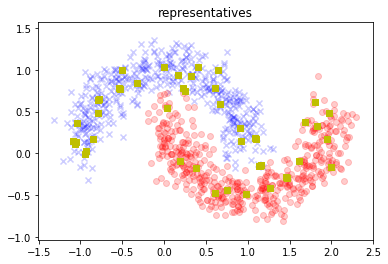

In [47]:
plt.rcParams['figure.figsize'] = (6,4)
plt.scatter(X1[:,0], X1[:,1], marker='x', c='b', alpha=0.2)
plt.scatter(X2[:,0], X2[:,1], marker='o', c='r',alpha=0.2)
plt.scatter(X[list(representatives),0], X[list(representatives),1], marker='s', c='y', alpha=1.0)
#plt.scatter(X[ind_min,0], X[ind_min,1], marker='o', c='g',alpha=1.0)
plt.axis('equal')
plt.title('representatives')
plt.show()

In [48]:
w_n,v_n = get_eig_Lnorm(W)
representatives_n = set([])
for i in range(50):
    v_i = v_n[:,-i]
    representatives_n = representatives_n.union([np.argmax(v_i)])
print(len(representatives_n))

50


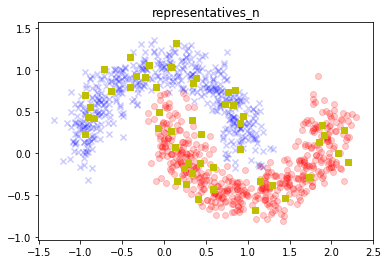

In [49]:
plt.rcParams['figure.figsize'] = (6,4)
plt.scatter(X1[:,0], X1[:,1], marker='x', c='b', alpha=0.2)
plt.scatter(X2[:,0], X2[:,1], marker='o', c='r',alpha=0.2)
plt.scatter(X[list(representatives_n),0], X[list(representatives_n),1], marker='s', c='y', alpha=1.0)
#plt.scatter(X[ind_min,0], X[ind_min,1], marker='o', c='g',alpha=1.0)
plt.axis('equal')
plt.title('representatives_n')
plt.show()